# Simple segmentation model

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
from functools import partial
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms.functional as TF

import albumentations as A

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 256

NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 80

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [4]:
warnings.simplefilter("ignore")

## Model

In [5]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
          nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [6]:
class Branch(nn.Module):
    def __init__(self, channels, block=None):
        super().__init__()
        middle_channels = channels * 2
        self.residual = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(channels, middle_channels, 3),
            block(middle_channels) if block is not None else nn.Identity(),
            ConvBlock(middle_channels, channels, 3, act=False),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.gamma = nn.Parameter(torch.zeros(1))
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x):
        out = x + self.gamma * self.residual(x)
        return self.act(out)

In [7]:
def get_branch(num):
    return partial(Branch, block = get_branch(num - 1)) if num > 0 else None

In [8]:
class Net(nn.Sequential):
    def __init__(self, classes, num_downsamplings, channels=32, in_channels=3):
        super().__init__(
            ConvBlock(in_channels, channels, 3),
            Branch(channels, get_branch(num_downsamplings - 1)),
            ConvBlock(channels, channels, 3),
            nn.Conv2d(channels, classes, 1)
        )

### Model creation

In [9]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [10]:
model = Net(classes=1, num_downsamplings=5).to(DEVICE)

In [11]:
model.apply(init_linear);

In [12]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 12,586,822


In [13]:
model

Net(
  (0): ConvBlock(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Branch(
    (residual): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Branch(
        (residual): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): ConvBlock(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True

## Data

### Transforms

In [14]:
class TransformFn:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, target):
        image = np.asarray(image)
        target = np.asarray(target)
        mask = (target == 1)
        mask = mask.astype(np.uint8, copy=False)

        transformed = self.transform(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']

        image = TF.to_tensor(image)
        mask = np.expand_dims(mask, axis=0)
        mask = torch.as_tensor(mask, dtype=torch.float)    
        return image, mask

In [15]:
train_transform = A.Compose([
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10),
        shear=(-8, 8),
        p=1
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
])

In [16]:
val_transform = A.Compose([
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE)
])

### Dataset

In [17]:
train_dset = datasets.OxfordIIITPet(root=DATA_DIR, split="trainval", target_types='segmentation', download=True,
                                    transforms=TransformFn(train_transform))

val_dset = datasets.OxfordIIITPet(root=DATA_DIR, split="test", target_types='segmentation', download=True,
                                  transforms=TransformFn(val_transform))

Data Loader

In [18]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=NUM_WORKERS, pin_memory=True)

### Plotting

In [19]:
def plot_image(image):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(image)
    plt.show()

In [20]:
def plot_tensor_image(image):
    image = TF.to_pil_image(image)
    plot_image(image)

In [21]:
def plot_image_mask(image, mask, color='red'):
    image = TF.convert_image_dtype(image, dtype=torch.uint8)
    mask = mask.to(torch.bool)
    image_masks = torchvision.utils.draw_segmentation_masks(image=image, masks=mask, alpha=0.5, colors=color)
    plot_tensor_image(image_masks)

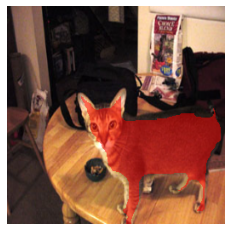

In [22]:
plot_image_mask(*val_dset[0])

## Metrics

In [23]:
class MeanDice(ignite.metrics.Metric):
    def __init__(self, threshold=0.5, smooth=0.01, output_transform=lambda x: x, device="cpu"):
        self.threshold = threshold
        self.smooth = smooth
        super().__init__(output_transform=output_transform, device=device)
    
    def reset(self):
        self._dice_sum = 0.
        self._num_examples = 0
        super().reset()
    
    def update(self, data):
        outputs, targets = data[0].detach(), data[1].detach()
        
        probs = torch.sigmoid(outputs)
        labels = (probs > self.threshold).float()
        
        num = outputs.size(0)
        m1 = labels.view(num, -1)
        m2 = targets.view(num, -1)
        
        intersection = (m1 * m2).sum(1)
        cardinality = m1.sum(1) + m2.sum(1)
        dice = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        
        self._dice_sum += torch.sum(dice).item()
        self._num_examples += num
        
    def compute(self):
        mean_dice = self._dice_sum / self._num_examples
        return mean_dice

## Training

### Setup Trainer

In [24]:
loss = nn.BCEWithLogitsLoss()

In [25]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [26]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

Trainer

In [27]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [28]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [29]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

Evaluator

In [30]:
val_metrics = {"mean Dice": MeanDice(), "loss": ignite.metrics.Loss(loss)}

In [31]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [32]:
history = defaultdict(list)

In [33]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_mean_dice = val_metrics["mean Dice"]
    history['val loss'].append(val_loss)
    history['val mean Dice'].append(val_mean_dice)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} mean Dice {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_mean_dice))

### Start training

In [33]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/80 - train: loss 0.795; val: loss 0.661 mean Dice 0.522
2/80 - train: loss 0.483; val: loss 0.413 mean Dice 0.673
3/80 - train: loss 0.354; val: loss 0.383 mean Dice 0.707
4/80 - train: loss 0.321; val: loss 0.308 mean Dice 0.750
5/80 - train: loss 0.290; val: loss 0.289 mean Dice 0.784
6/80 - train: loss 0.268; val: loss 0.282 mean Dice 0.783
7/80 - train: loss 0.256; val: loss 0.254 mean Dice 0.803
8/80 - train: loss 0.247; val: loss 0.336 mean Dice 0.765
9/80 - train: loss 0.248; val: loss 0.252 mean Dice 0.799
10/80 - train: loss 0.232; val: loss 0.266 mean Dice 0.786
11/80 - train: loss 0.214; val: loss 0.279 mean Dice 0.793
12/80 - train: loss 0.213; val: loss 0.216 mean Dice 0.819
13/80 - train: loss 0.204; val: loss 0.246 mean Dice 0.818
14/80 - train: loss 0.205; val: loss 0.280 mean Dice 0.802
15/80 - train: loss 0.196; val: loss 0.234 mean Dice 0.790
16/80 - train: loss 0.187; val: loss 0.211 mean Dice 0.831
17/80 - train: loss 0.184; val: loss 0.204 mean Dice 0.847
18/80 

In [34]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [35]:
def plot_history(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '.-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

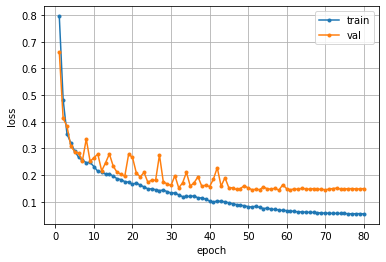

In [36]:
plot_history_train_val(history, 'loss')

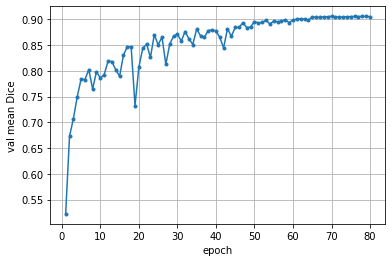

In [37]:
plot_history(history, 'val mean Dice')

## Testing

In [38]:
model.eval();

In [48]:
def compare_detection(model, image, target, threshold=0.5):
    image_device = image.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(image_device)
    logits = logits.detach().cpu().squeeze(0)
    probs = torch.sigmoid(logits)
    pred_mask = probs > threshold
    
    image = TF.convert_image_dtype(image, dtype=torch.uint8)
    gt_mask = target.to(torch.bool)
    image_masks = torchvision.utils.draw_segmentation_masks(image=image, masks=pred_mask, alpha=0.5, colors='red')
    image_masks = torchvision.utils.draw_segmentation_masks(image=image_masks, masks=gt_mask, alpha=0.5, colors='green')
    plot_tensor_image(image_masks)

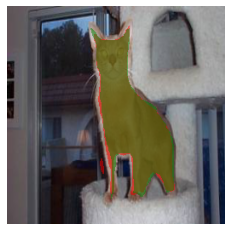

In [49]:
compare_detection(model, *val_dset[1])